# 0. Import Libraries

In [2]:
import pandas as pd
import numpy as np
from my_krml_25246568.data.sets import pop_target
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
import xgboost as xgb
from joblib import dump
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin 
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 1. Load Data

In [3]:
df = pd.read_csv('../data/processed/processed_data_final.csv', low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13519999 entries, 0 to 13519998
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   startingAirport           float64
 1   destinationAirport        float64
 2   totalTravelDistance       float64
 3   travelDurationMins        float64
 4   cabinTypeSegmentSegment1  float64
 5   cabinTypeSegmentSegment2  float64
 6   cabinTypeSegmentSegment3  float64
 7   cabinTypeSegmentSegment4  float64
 8   numStops                  float64
 9   flightMonth               float64
 10  flightDay                 float64
 11  flightHour                float64
 12  flightMinute              float64
 13  days_difference           float64
 14  totalFare                 float64
dtypes: float64(15)
memory usage: 1.5 GB


In [5]:
df.head()

,startingAirport,destinationAirport,totalTravelDistance,travelDurationMins,cabinTypeSegmentSegment1,cabinTypeSegmentSegment2,cabinTypeSegmentSegment3,cabinTypeSegmentSegment4,numStops,flightMonth,flightDay,flightHour,flightMinute,days_difference,totalFare
0,0.964373,-1.603932,0.710709,0.244224,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.582158,0.025652,1.695090,0.212696,103.98
1,0.964373,-1.603932,1.025539,-0.193447,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.582158,-1.200963,1.589283,0.212696,216.58
2,0.964373,-1.603932,1.025539,0.578117,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.468623,1.497591,-1.108799,0.155061,216.58
3,0.964373,-1.603932,1.025539,-0.184423,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.582158,0.270975,1.589283,0.212696,237.58
4,0.964373,-1.603932,1.551857,1.958812,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.582158,0.393637,0.795729,0.212696,307.21


In [6]:
df.shape

(13519999, 15)

# 2. Split Dataset

## [2.1] Sampling dataset

Sampling the dataset based on the origin destination pair, so that all the pairs are included in the sample

In [7]:
# fraction of each group to sample
sample_fraction = 0.3

In [8]:
# Perform stratified sampling by 'startingAirport' and 'destinationAirport'
sampled_df = df.groupby(['startingAirport', 'destinationAirport'], group_keys=False).apply(lambda x: x.sample(frac=sample_fraction))

/var/folders/y7/4mw_ll2n3zz0kzg7v6kt7kwm0000gn/T/ipykernel_6018/1789080720.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(['startingAirport', 'destinationAirport'], group_keys=False).apply(lambda x: x.sample(frac=sample_fraction))


In [9]:
# Reset index
sampled_df = sampled_df.reset_index(drop=True)

In [10]:
sampled_df.shape

(4055994, 15)

## [2.2] Splitting Sampled Data

### Extracting target variable

In [11]:
sampled_df, target = pop_target(sampled_df, 'totalFare')

### Splitting into training and validation

In [12]:
X_train, X_val, y_train, y_val = train_test_split(sampled_df, target, test_size=0.3, random_state=42)

### Splitting validation into validation and testing

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# 3. Baseline Model

In [14]:
y_mean = y_train.mean()
y_mean

373.72073724418357

In [15]:
y_base = np.full(y_train.shape, y_mean)
print("RMSE on Training Data:", rmse(y_train, y_base))

RMSE on Training Data: 207.1543109656579


In [16]:
y_mean_val = y_val.mean()
y_mean_val

373.6187594161069

In [17]:
y_val_base = np.full(y_val.shape, y_mean_val)
print("RMSE on Validation Data:", rmse(y_val, y_val_base))

RMSE on Validation Data: 207.45034952640196


In [18]:
y_mean_test = y_test.mean()
y_mean_test

373.56756347797506

In [19]:
y_test_base = np.full(y_test.shape, y_mean_test)
print("RMSE on Testing Data:", rmse(y_test, y_test_base))

RMSE on Testing Data: 206.85948547370114


# 4. XGBoost Model

## [4.1] Model 1

In [20]:
xgb_1 = xgb.XGBRegressor()

In [21]:
xgb_1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
y_train_pred = xgb_1.predict(X_train)
train_rmse = rmse(y_train, y_train_pred)
print("Training RMSE: ",train_rmse)

Training RMSE:  114.12782161665643


In [23]:
y_val_pred = xgb_1.predict(X_val)
val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE: ",val_rmse)

Validation RMSE:  115.04400212685007


## [4.2] Model 2 - Hyperopt

In [24]:
rstate = np.random.default_rng(42)

In [25]:
space = {
    'max_depth' : hp.choice('max_depth', range(3, 15, 1)),
    'min_child_weight' : hp.choice('min_child_weight', range(3, 15, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.4, 0.05),
    'subsample' : hp.quniform('subsample', 0.7, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.2, 0.5, 0.05)
}

In [26]:
def objective(space):
    xgboost = xgb.XGBRegressor(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree']
    )

    # Calculate cross-validated RMSE
    neg_rmse = cross_val_score(xgboost, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()

    return {'loss': neg_rmse, 'status': STATUS_OK}

In [27]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=3,
    rstate=rstate
)

100%|██████████| 3/3 [01:00<00:00, 20.29s/trial, best loss: -139.74568039214472]


In [28]:
print("Best hyperparameters:", best)

Best hyperparameters: {'colsample_bytree': 0.25, 'learning_rate': 0.25, 'max_depth': 0, 'min_child_weight': 3, 'subsample': 0.75}


In [29]:
xgboost2 = xgb.XGBRegressor(
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree']
)

In [30]:
xgboost2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.25, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
y_train_pred = xgboost2.predict(X_train)
train_rmse = rmse(y_train, y_train_pred)
print("Training RMSE: ",train_rmse)

Training RMSE:  80.49756352966048


In [32]:
y_val_pred = xgboost2.predict(X_val)
val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE: ",val_rmse)

Validation RMSE:  89.39813801367333


## [4.3] Model 3 - Hyperopt

In [33]:
rstate = np.random.default_rng(42)

In [34]:
space = {
    'max_depth' : hp.choice('max_depth', range(3, 15, 1)),
    'min_child_weight' : hp.choice('min_child_weight', range(3, 15, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.4, 0.05),
    'subsample' : hp.quniform('subsample', 0.7, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.2, 0.5, 0.05),
    'n_estimators': hp.choice('n_estimators', range(50, 500, 50)),
    'reg_alpha': hp.quniform('reg_alpha', 0, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 0, 1, 0.1)
}

In [35]:
def objective(space):
    xgboost = xgb.XGBRegressor(
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        n_estimators=space['n_estimators'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda']
    )

    # Calculate cross-validated RMSE
    neg_rmse = cross_val_score(xgboost, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()

    return {'loss': neg_rmse, 'status': STATUS_OK}

In [36]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=3,
    rstate=rstate
)

100%|██████████| 3/3 [04:39<00:00, 93.14s/trial, best loss: -120.09539104113298]


In [37]:
print("Best hyperparameters:", best)

Best hyperparameters: {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 3, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001, 'subsample': 0.9500000000000001}


In [38]:
xgboost3 = xgb.XGBRegressor(
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    n_estimators = best['n_estimators'],
    reg_alpha = best['reg_alpha'],
    reg_lambda = best['reg_lambda']
)

In [39]:
xgboost3.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
y_train_pred = xgboost3.predict(X_train)
train_rmse = rmse(y_train, y_train_pred)
print("Training RMSE: ",train_rmse)

Training RMSE:  198.29063805977432


In [41]:
y_val_pred = xgboost3.predict(X_val)
val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE: ",val_rmse)

Validation RMSE:  198.54378612224127


## [4.4] Model 4 - Randomised Search

In [42]:
# Define the parameter grid for random search
param_dist = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.7, 1.0, 5),
    'colsample_bytree': np.linspace(0.2, 0.8, 5),
    'reg_alpha': np.linspace(0, 1, 10),     # L1 regularization
    'reg_lambda': np.linspace(0, 1, 10)     # L2 regularization
}

In [43]:
# Initialize the XGBoost regressor
xgboost4 = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [44]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgboost4,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    scoring='neg_root_mean_squared_error',  # For regression RMSE scoring
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42
)

In [45]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]),
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.7  , 0.775, 0.85 , 0.925, 1.   ])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [46]:
# Output the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best RMSE score from random search: ", -random_search.best_score_)

Best parameters found:  {'subsample': 1.0, 'reg_lambda': 0.8888888888888888, 'reg_alpha': 0.2222222222222222, 'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.23555555555555557, 'colsample_bytree': 0.8}
Best RMSE score from random search:  73.4410909854235


In [47]:
y_train_pred = random_search.predict(X_train)
train_rmse = rmse(y_train, y_train_pred)
print("Training RMSE: ",train_rmse)

Training RMSE:  49.95667924292511


In [48]:
y_val_pred = random_search.predict(X_val)
val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE: ",val_rmse)

Validation RMSE:  72.299421208702


## [4.5] Model 5

In [49]:
xgboost5 = xgb.XGBRegressor(
    max_depth = random_search.best_params_['max_depth'],
    learning_rate = random_search.best_params_['learning_rate'],
    subsample = random_search.best_params_['subsample'],
    colsample_bytree = random_search.best_params_['colsample_bytree'],
    n_estimators = random_search.best_params_['n_estimators'],
    reg_alpha = random_search.best_params_['reg_alpha'],
    reg_lambda = random_search.best_params_['reg_lambda']
)

In [50]:
xgboost5.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.23555555555555557,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
y_train_pred = xgboost5.predict(X_train)
train_rmse = rmse(y_train, y_train_pred)
print("Training RMSE: ",train_rmse)

Training RMSE:  49.95667924292511


In [52]:
y_val_pred = xgboost5.predict(X_val)
val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE: ",val_rmse)

Validation RMSE:  72.299421208702


# 5. Feature Importance Graph

<Figure size 1000x800 with 0 Axes>

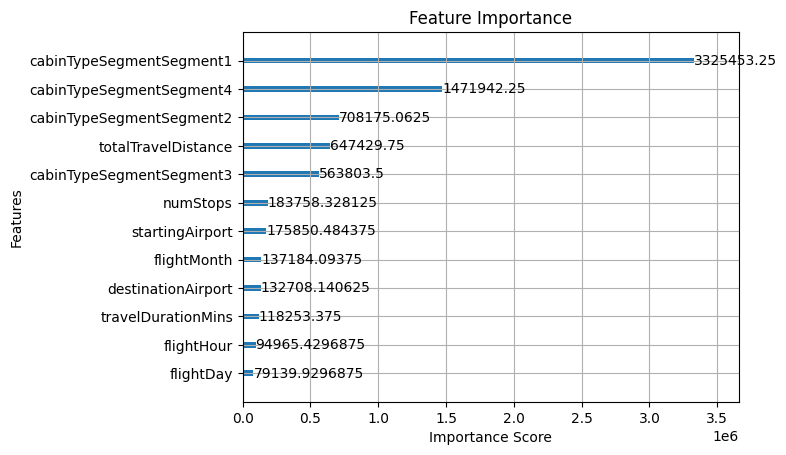

In [53]:
plt.figure(figsize=(10, 8))
plot_importance(xgboost5, importance_type='gain', max_num_features=12)  # Adjust 'importance_type' as needed
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 6. Permutation Importance

In [54]:
# Compute permutation importance
perm_importance = permutation_importance(xgboost5, X_val, y_val, scoring='neg_root_mean_squared_error', n_repeats=10, random_state=42)

In [55]:
# Display the results
feature_importance_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                     Feature  Importance
2        totalTravelDistance  175.734413
1         destinationAirport   83.553956
0            startingAirport   80.066688
3         travelDurationMins   67.673575
10                 flightDay   52.024664
5   cabinTypeSegmentSegment2   43.007254
9                flightMonth   40.760589
11                flightHour   35.553972
13           days_difference   28.564807
12              flightMinute   22.610027
6   cabinTypeSegmentSegment3   19.139814
4   cabinTypeSegmentSegment1   18.514673
8                   numStops    2.667410
7   cabinTypeSegmentSegment4    1.553009


# Testing set results for best model

In [56]:
y_test_pred = xgboost5.predict(X_test)
test_rmse = rmse(y_test, y_test_pred)
print("Testing RMSE: ",test_rmse)

Testing RMSE:  72.62337738788462


In [57]:
dump(xgboost5,  '../models/xgboost5_final.joblib')

['../models/xgboost5_final.joblib']